# Spotify: Top 200 Weekly (Global) Song Analysis

## Preprocessing & Modeling

For preprocessing and modeling, I first did some initial modeling utilizing Pipelines to see what scores I would get by adding the features from [Part 1](./01_Data_Cleaning_and_EDA.ipynb).
Initial models:
- Linear Regression: I chose linear regression because it's a fast and easy model to run. I knew that the LINE Assumptions were violated (non-linear), but I wanted to see what a baseline score would look like. I also wanted to see if using LASSO could help in reducing coefficients once running the polynomial features.
- Decision Tree: Because I knew that linear regression would probably not be the best model to run, another regression model is a decision tree.
- Random Forest: In case of overfitting and accuracy of the model, I chose to include random forest.
- Extra Trees: In case of overfitting and accuracy of the model, I chose to include extra trees.


After running the initial models, I decided to tune and utilize Gridsearch on Random Forest because it represented the best R2 score and had the least overfitting of the other three models.

To tune the model, I did some preprocessing steps such as adding polynomial features, and one-hot encoding certain categorical features.

### Contents:
- [Preprocessing](#Preprocessing)
- [Modeling](#Modeling)
- [Model Performance on Training/Test Data](#Model-Performance-on-Training/Test-Data)
- [Conclusion](#Conclusion)

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Ridge
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
# Read in the Dataset
df = pd.read_csv('./datasets/spotify_1_df.csv')

In [3]:
# Reset Index
df = df.reset_index()
pd.set_option('display.max_columns', None)
df.head()

,index,Index,highest_charting_position,number_of_times_charted,week_of_highest_charting,song_name,streams,artist,artist_followers,genre,release_date,weeks_charted,popularity,danceability,energy,loudness,speechiness,acousticness,liveness,tempo,duration_ms,valence,chord,start_week_highest_charting,end_week_highest_charting,contemporary,dance,edm,electropop,hip hop,house,indie,latin,other,pop,rap,reggaeton,rock,trap
0,0,1,1,8,2021-07-23--2021-07-30,Beggin',48633449.0,Måneskin,3377762.0,"['indie rock italiano', 'italian pop']",2017-12-08,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,100.0,0.714,0.800,-4.808,0.0504,0.1270,0.3590,134.002,211560.0,0.589,B,2021-07-23,2021-07-30,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),47248719.0,The Kid LAROI,2230022.0,['australian hip hop'],2021-07-09,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,99.0,0.591,0.764,-5.484,0.0483,0.0383,0.1030,169.928,141806.0,0.478,C#/Db,2021-07-23,2021-07-30,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2,3,1,11,2021-06-25--2021-07-02,good 4 u,40162559.0,Olivia Rodrigo,6266514.0,['pop'],2021-05-21,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,99.0,0.563,0.664,-5.044,0.1540,0.3350,0.0849,166.928,178147.0,0.688,A,2021-06-25,2021-07-02,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,3,4,3,5,2021-07-02--2021-07-09,Bad Habits,37799456.0,Ed Sheeran,83293380.0,"['pop', 'uk pop']",2021-06-25,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,98.0,0.808,0.897,-3.712,0.0348,0.0469,0.3640,126.026,231041.0,0.591,B,2021-07-02,2021-07-09,0,0,0,0,0,0,0,0,0,2,0,0,0,0
4,4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),33948454.0,Lil Nas X,5473565.0,"['lgbtq+ hip hop', 'pop rap']",2021-07-23,2021-07-23--2021-07-30,96.0,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000.0,0.894,D#/Eb,2021-07-23,2021-07-30,0,0,0,0,1,0,0,0,0,0,1,0,0,0


In [4]:
df = df.drop('Index', 1)

## Preprocessing

#### Polynomial Features

First, I am going to create polynomial features for only the audio features in this dataset (ex. danceability, energy, etc.). Because there is little correlation between `popularity` and the other features in the dataset, I am creating polynomial features to engineer new features that may have interaction with one another, hopefully increasing model performance.

In [5]:
# Define Features
features = ['danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'liveness', 'tempo', 'valence']
X = df[features]

In [6]:
# Instantiate PolynomialFeatures
poly = PolynomialFeatures(include_bias=False)

In [7]:
# Fit & Transform X
X_poly = poly.fit_transform(X)

In [8]:
pd.DataFrame(X_poly)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
0,0.714,0.800,-4.808,0.0504,0.12700,0.3590,134.002,0.589,0.509796,0.571200,-3.432912,0.035986,0.090678,0.256326,95.677428,0.420546,0.640000,-3.846400,0.040320,0.101600,0.287200,107.201600,0.471200,23.116864,-0.242323,-0.610616,-1.726072,-644.281616,-2.831912,0.002540,0.006401,0.018094,6.753701,0.029686,0.016129,0.045593,17.018254,0.074803,0.128881,48.106718,0.211451,17956.536004,78.927178,0.346921
1,0.591,0.764,-5.484,0.0483,0.03830,0.1030,169.928,0.478,0.349281,0.451524,-3.241044,0.028545,0.022635,0.060873,100.427448,0.282498,0.583696,-4.189776,0.036901,0.029261,0.078692,129.824992,0.365192,30.074256,-0.264877,-0.210037,-0.564852,-931.885152,-2.621352,0.002333,0.001850,0.004975,8.207522,0.023087,0.001467,0.003945,6.508242,0.018307,0.010609,17.502584,0.049234,28875.525184,81.225584,0.228484
2,0.563,0.664,-5.044,0.1540,0.33500,0.0849,166.928,0.688,0.316969,0.373832,-2.839772,0.086702,0.188605,0.047799,93.980464,0.387344,0.440896,-3.349216,0.102256,0.222440,0.056374,110.840192,0.456832,25.441936,-0.776776,-1.689740,-0.428236,-841.984832,-3.470272,0.023716,0.051590,0.013075,25.706912,0.105952,0.112225,0.028442,55.920880,0.230480,0.007208,14.172187,0.058411,27864.957184,114.846464,0.473344
3,0.808,0.897,-3.712,0.0348,0.04690,0.3640,126.026,0.591,0.652864,0.724776,-2.999296,0.028118,0.037895,0.294112,101.829008,0.477528,0.804609,-3.329664,0.031216,0.042069,0.326508,113.045322,0.530127,13.778944,-0.129178,-0.174093,-1.351168,-467.808512,-2.193792,0.001211,0.001632,0.012667,4.385705,0.020567,0.002200,0.017072,5.910619,0.027718,0.132496,45.873464,0.215124,15882.552676,74.481366,0.349281
4,0.736,0.704,-7.409,0.0615,0.02030,0.0501,149.995,0.894,0.541696,0.518144,-5.453024,0.045264,0.014941,0.036874,110.396320,0.657984,0.495616,-5.215936,0.043296,0.014291,0.035270,105.596480,0.629376,54.893281,-0.455653,-0.150403,-0.371191,-1111.312955,-6.623646,0.003782,0.001248,0.003081,9.224692,0.054981,0.000412,0.001017,3.044898,0.018148,0.002510,7.514749,0.044789,22498.500025,134.095530,0.799236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1540,0.762,0.700,-6.021,0.0694,0.00261,0.1530,116.073,0.608,0.580644,0.533400,-4.588002,0.052883,0.001989,0.116586,88.447626,0.463296,0.490000,-4.214700,0.048580,0.001827,0.107100,81.251100,0.425600,36.252441,-0.417857,-0.015715,-0.921213,-698.875533,-3.660768,0.004816,0.000181,0.010618,8.055466,0.042195,0.000007,0.000399,0.302951,0.001587,0.023409,17.759169,0.093024,13472.941329,70.572384,0.369664
1541,0.528,0.870,-3.123,0.0851,0.24000,0.3330,152.370,0.714,0.278784,0.459360,-1.648944,0.044933,0.126720,0.175824,80.451360,0.376992,0.756900,-2.717010,0.074037,0.208800,0.289710,132.561900,0.621180,9.753129,-0.265767,-0.749520,-1.039959,-475.851510,-2.229822,0.007242,0.020424,0.028338,12.966687,0.060761,0.057600,0.079920,36.568800,0.171360,0.110889,50.739210,0.237762,23216.616900,108.792180,0.509796
1542,0.765,0.523,-4.333,0.0300,0.18400,0.1320,104.988,0.394,0.585225,0.400095,-3.314745,0.022950,0.140760,0.100980,80.315820,0.301410,0.273529,-2.266159,0.015690,0.096232,0.069036,54.908724,0.206062,18.774889,-0.129990,-0.797272,-0.571956,-454.913004,-1.707202,0.000900,0.005520,0.003960,3.149640,0.011820,0.033856,0.024288,19.317792,0.072496,0.017424,13.858416,0.052008,11022.480144,41.365272,0.155236
1543,0.832,0.550,-7.026,0.0587,0.24900,0.1820,154.064,0.881,0.692224,0.457600,-5.845632,0.048838,0.207168,0.151424,128.181248,0.732992,0.302500,-3.864300,0.032285,0.136950,0.100100,84.735200,0.484550,49.364676,-0.412426,-1.749474,-1.278732,-1082.453664,-6.189906,0.003446,0.014616,0.010683,9.043557,0.051715,0.062001,0.045318,38.361936,0.219369,0.033124,28.039648,0.160342,23735.716096,135.730384,0.776161


In [9]:
# All the feature names from PolynomialFeatures
poly.get_feature_names(features)

['danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'liveness',
 'tempo',
 'valence',
 'danceability^2',
 'danceability energy',
 'danceability loudness',
 'danceability speechiness',
 'danceability acousticness',
 'danceability liveness',
 'danceability tempo',
 'danceability valence',
 'energy^2',
 'energy loudness',
 'energy speechiness',
 'energy acousticness',
 'energy liveness',
 'energy tempo',
 'energy valence',
 'loudness^2',
 'loudness speechiness',
 'loudness acousticness',
 'loudness liveness',
 'loudness tempo',
 'loudness valence',
 'speechiness^2',
 'speechiness acousticness',
 'speechiness liveness',
 'speechiness tempo',
 'speechiness valence',
 'acousticness^2',
 'acousticness liveness',
 'acousticness tempo',
 'acousticness valence',
 'liveness^2',
 'liveness tempo',
 'liveness valence',
 'tempo^2',
 'tempo valence',
 'valence^2']

In [10]:
# Creating a dataframe for the polynomial features
poly_features = pd.DataFrame(X_poly, columns=poly.get_feature_names(features))

In [11]:
# Correlation Matrix for Polynomial Features 
poly_features.corr()

,danceability,energy,loudness,speechiness,acousticness,liveness,tempo,valence,danceability^2,danceability energy,danceability loudness,danceability speechiness,danceability acousticness,danceability liveness,danceability tempo,danceability valence,energy^2,energy loudness,energy speechiness,energy acousticness,energy liveness,energy tempo,energy valence,loudness^2,loudness speechiness,loudness acousticness,loudness liveness,loudness tempo,loudness valence,speechiness^2,speechiness acousticness,speechiness liveness,speechiness tempo,speechiness valence,acousticness^2,acousticness liveness,acousticness tempo,acousticness valence,liveness^2,liveness tempo,liveness valence,tempo^2,tempo valence,valence^2
danceability,1.000000,0.142130,0.234928,0.237394,-0.316798,-0.114518,-0.040219,0.361627,0.989593,0.682162,-0.374561,0.426321,-0.060905,0.161308,0.647857,0.630083,0.093751,0.067933,0.227837,-0.204063,-0.067169,0.052120,0.306525,-0.244377,-0.144927,0.350099,0.210107,0.211920,-0.159105,0.134654,-0.048721,0.035549,0.202565,0.308438,-0.347133,-0.260159,-0.307472,-0.091850,-0.101768,-0.121256,0.051526,-0.077460,0.270681,0.334322
energy,0.142130,1.000000,0.732616,0.023989,-0.542399,0.124693,0.113352,0.356325,0.110626,0.801048,0.584780,0.019278,-0.467220,0.155959,0.168264,0.316260,0.983312,-0.114389,0.243791,-0.161573,0.379765,0.743222,0.683335,-0.664723,0.191714,0.649827,0.210978,0.572505,0.206366,-0.017185,-0.211368,0.023625,0.042682,0.121765,-0.567880,-0.259693,-0.471109,-0.266180,0.114255,0.152459,0.248925,0.108013,0.344669,0.327880
loudness,0.234928,0.732616,1.000000,-0.018823,-0.477431,0.043141,0.104371,0.298762,0.204692,0.653988,0.780003,0.007914,-0.371662,0.113855,0.227605,0.315176,0.684818,0.459509,0.150079,-0.139533,0.238950,0.553348,0.523762,-0.945352,0.337434,0.743736,0.400842,0.809421,0.446926,-0.072370,-0.260472,-0.057367,0.012268,0.074652,-0.538522,-0.290830,-0.415981,-0.237160,0.032402,0.074929,0.156278,0.100597,0.293986,0.275196
speechiness,0.237394,0.023989,-0.018823,1.000000,-0.131436,0.072774,0.111255,0.038032,0.252179,0.140493,-0.172031,0.959412,-0.084738,0.120531,0.252070,0.103089,-0.005877,-0.114442,0.948534,-0.086468,0.044558,0.084338,0.015525,0.002093,-0.873118,0.099145,-0.128722,-0.073979,-0.075506,0.930556,0.536283,0.645162,0.938035,0.858488,-0.135688,0.035358,-0.113616,-0.065908,0.080210,0.096157,0.068050,0.121834,0.074699,0.014968
acousticness,-0.316798,-0.542399,-0.477431,-0.131436,1.000000,-0.005469,-0.061632,-0.096997,-0.303751,-0.543988,-0.214962,-0.177958,0.935462,-0.085819,-0.258097,-0.176393,-0.482339,0.091441,-0.221841,0.852252,-0.137800,-0.391057,-0.268215,0.490795,-0.026614,-0.882976,-0.196818,-0.372272,-0.207439,-0.057276,0.478649,-0.004298,-0.141977,-0.113153,0.950207,0.630831,0.938308,0.789635,0.014359,-0.015949,-0.006987,-0.051114,-0.094737,-0.070234
liveness,-0.114518,0.124693,0.043141,0.072774,-0.005469,1.000000,-0.018265,0.007882,-0.113884,0.018224,0.112137,0.027226,-0.028719,0.937606,-0.093178,-0.045263,0.132779,-0.052858,0.078516,0.054876,0.939548,0.074485,0.056490,-0.025722,-0.095894,0.014002,-0.815894,0.052240,0.016159,0.117508,0.134996,0.559119,0.055254,0.057043,-0.018941,0.565016,-0.002354,0.045225,0.942216,0.935042,0.829674,-0.020496,0.004220,0.006093
tempo,-0.040219,0.113352,0.104371,0.111255,-0.061632,-0.018265,1.000000,0.057563,-0.045094,0.043905,0.106353,0.093090,-0.067881,-0.029599,0.715211,0.021421,0.103514,0.003564,0.133007,0.002032,0.015966,0.727563,0.090404,-0.097205,-0.045339,0.084895,0.065246,-0.453554,0.026576,0.083848,-0.003978,0.036998,0.367258,0.102996,-0.067127,-0.034062,0.189626,-0.005215,-0.020217,0.265720,0.021347,0.991843,0.502779,0.067396
valence,0.361627,0.356325,0.298762,0.038032,-0.096997,0.007882,0.057563,1.000000,0.353575,0.479004,0.090823,0.090013,0.005625,0.093432,0.283422,0.934143,0.354361,0.056785,0.105442,0.066147,0.098413,0.279965,0.899410,-0.237644,0.046155,0.172734,0.110478,0.235095,-0.638199,0.024995,0.017108,0.014544,0.039653,0.407137,-0.133575,0.0001

Because there were 36 new features created from the initial 8 features, the correlation matrix above is going to be hard to read and understand the correlation between each features. Below, I decided to look into the highest and lowest correlation each new feature had with `popularity`.

In [12]:
# Combining polynomial features with df
poly_features_df = df.join(poly_features.loc[:,['danceability^2', 'danceability energy',
       'danceability loudness', 'danceability speechiness',
       'danceability acousticness', 'danceability liveness',
       'danceability tempo', 'danceability valence', 'energy^2',
       'energy loudness', 'energy speechiness', 'energy acousticness',
       'energy liveness', 'energy tempo', 'energy valence', 'loudness^2',
       'loudness speechiness', 'loudness acousticness', 'loudness liveness',
       'loudness tempo', 'loudness valence', 'speechiness^2',
       'speechiness acousticness', 'speechiness liveness', 'speechiness tempo',
       'speechiness valence', 'acousticness^2', 'acousticness liveness',
       'acousticness tempo', 'acousticness valence', 'liveness^2',
       'liveness tempo', 'liveness valence', 'tempo^2', 'tempo valence',
       'valence^2']], how="left", on=df.index)

#### Correlations - Polynomial Features

In [13]:
# Highest Correlations with `popularity`
poly_features_df.corr()['popularity'].sort_values(ascending=False).head(10)

popularity                 1.000000
number_of_times_charted    0.232796
loudness                   0.158767
loudness tempo             0.151205
loudness acousticness      0.149921
pop                        0.123384
streams                    0.123184
danceability loudness      0.121784
loudness valence           0.118661
artist_followers           0.104358
Name: popularity, dtype: float64

Looking at the above correlations with `popularity` after adding in the polynomial features, I found that from the 10 most positively correlated features (from the polynomial features set) were `loudness tempo`, `loudness acousticness`, `danceability loudness`, and `loudness valence`. I will create scatterplots against `popularity` to further investigate the relationships.

In [14]:
# Smallest Correlations with `popularity`
poly_features_df.corr()['popularity'].sort_values(ascending=False).tail(10)

speechiness acousticness    -0.063612
danceability acousticness   -0.070984
acousticness liveness       -0.084290
acousticness                -0.091245
acousticness valence        -0.092157
acousticness tempo          -0.094187
acousticness^2              -0.111161
highest_charting_position   -0.164167
loudness^2                  -0.174674
index                       -0.333685
Name: popularity, dtype: float64

Looking at the above correlations with `popularity` after adding in the polynomial features, I found that the 10 most negatively correlated features (from the polynomial features set) were `speechiness acousticness`, `danceability acousticness`, `acousticness liveness`, `acousticness valence`, `acousticness tempo`, `acoustiness^2`, and `loudness^2`. I will create scatterplots against `popularity` to further investigate the relationships.

#### Scatter Plots - Polynomial Features

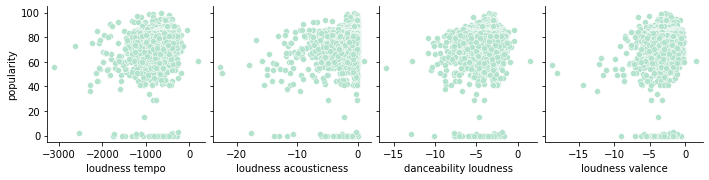

In [15]:
# Scatter Plots for Top Positively Correlated Polynomial Features with `popularity`
sns.set_palette(sns.color_palette("Pastel2"))
sns.pairplot(data=poly_features_df, y_vars=['popularity'], x_vars=['loudness tempo', 'loudness acousticness', 'danceability loudness',
                                                                  'loudness valence']);

There does not seem to be a linear pattern from the above scatter plots. Each scatter plot above seems to all be in a cluster with multiple plots with 0 popularity as potential outliers.

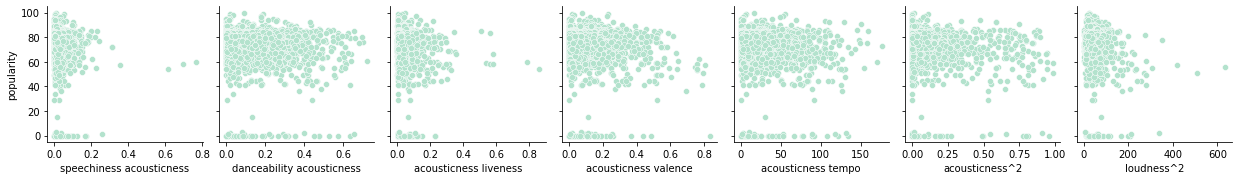

In [16]:
# Scatter Plots for Top Negatively Correlated Polynomial Features with `popularity`
sns.pairplot(data=poly_features_df, y_vars=['popularity'], x_vars=['speechiness acousticness', 'danceability acousticness', 'acousticness liveness',
                                                                  'acousticness valence', 'acousticness tempo', 'acousticness^2', 'loudness^2']);

Again, with the scatter plots above, there seems to be dots on the plots that have no popularity and may be potential outliers. In `loudness^2`, `acousticness liveness`, and `speechiness acousticness`, there is a cluster, while `danceability acousticness`, `acousticness valence`, `acousticness tempo`, `acousticness^2` have more of a straight line and is not decreasing or increasing in linearity.

#### Histogram - Polynomial Features

Next, I decided to look into the distribution for the polynomial features. I broke this down into two cells to be able to see the histograms in further detail.

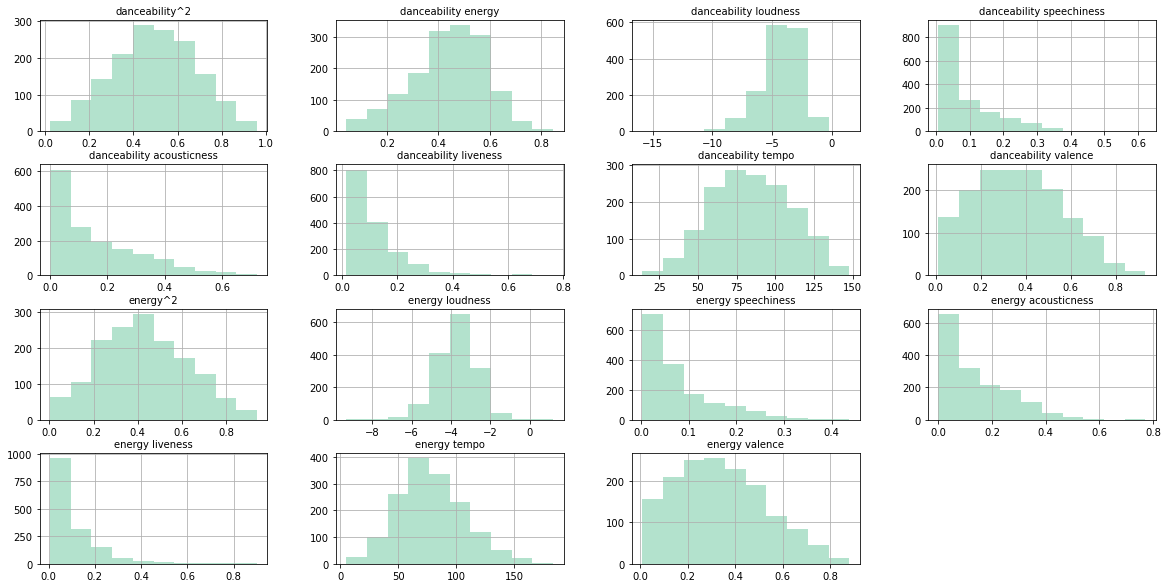

In [17]:
# Histograms for Polynomial Features
params = {'axes.titlesize':'10',
          'xtick.labelsize':'10',
          'ytick.labelsize':'10'}
plt.rcParams.update(params)

poly_features_df.hist(column=['danceability^2', 'danceability energy', 'danceability loudness',
       'danceability speechiness', 'danceability acousticness',
       'danceability liveness', 'danceability tempo', 'danceability valence',
       'energy^2', 'energy loudness', 'energy speechiness',
       'energy acousticness', 'energy liveness', 'energy tempo',
       'energy valence'], figsize=(20, 10));

From the above histograms, I found that `danceability^2`, `danceability energy`, `danceability loudness`, `danceability tempo`, `energy^2`, `energy loudness`, and `energy tempo` all had a normal distribution. I am going to add these features into my model first to test whether or not these polynomial features help with the model score.

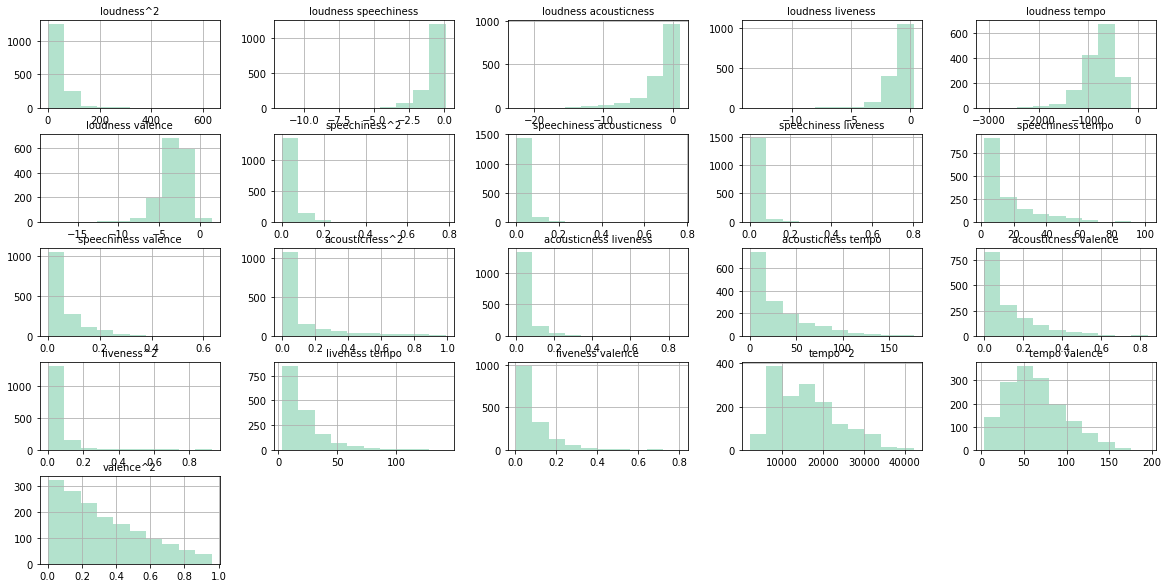

In [18]:
# Histograms for Polynomial Features
params = {'axes.titlesize':'10',
          'xtick.labelsize':'10',
          'ytick.labelsize':'10'}
plt.rcParams.update(params)

poly_features_df.hist(column=['loudness^2', 'loudness speechiness',
       'loudness acousticness', 'loudness liveness', 'loudness tempo',
       'loudness valence', 'speechiness^2', 'speechiness acousticness',
       'speechiness liveness', 'speechiness tempo', 'speechiness valence',
       'acousticness^2', 'acousticness liveness', 'acousticness tempo',
       'acousticness valence', 'liveness^2', 'liveness tempo',
       'liveness valence', 'tempo^2', 'tempo valence', 'valence^2'], figsize=(20, 10));

From the above histograms, I found that there was not as much of a normal distribution when compared to the first set of histograms plotted.

In [19]:
poly_features_df.shape

(1545, 74)

In [20]:
# poly_features_df to CSV
poly_features_df.to_csv('./datasets/poly_features_df.csv', index=True)

#### Christmas Songs Outliers

In [Part 1](./01_Data_Cleaning_and_EDA.ipynb) in the EDA portion of this project, I identified that there were outliers in the date '2020-12-18--2020-12-25' in `week_of_highest_charting` due to the increase in Christmas songs played and hitting the top charts for that week only.

In [21]:
df[df['week_of_highest_charting']=='2020-12-18--2020-12-25']

,index,highest_charting_position,number_of_times_charted,week_of_highest_charting,song_name,streams,artist,artist_followers,genre,release_date,weeks_charted,popularity,danceability,energy,loudness,speechiness,acousticness,liveness,tempo,duration_ms,valence,chord,start_week_highest_charting,end_week_highest_charting,contemporary,dance,edm,electropop,hip hop,house,indie,latin,other,pop,rap,reggaeton,rock,trap
615,615,1,10,2020-12-18--2020-12-25,All I Want for Christmas Is You,23235257.0,Mariah Carey,6931357.0,"['dance pop', 'pop', 'r&b', 'urban contemporary']",1994-11-01,2020-12-25--2021-01-01\n2020-12-18--2020-12-25...,65.0,0.336,0.627,-7.463,0.0384,0.1640,0.0708,150.273,241107.0,0.350,G,2020-12-18,2020-12-25,1,0,0,0,0,0,0,0,1,2,0,0,0,0
616,616,2,8,2020-12-18--2020-12-25,Last Christmas,20709328.0,Wham!,1631876.0,"['disco', 'europop', 'new romantic', 'new wave...",1984-11-29,2020-12-25--2021-01-01\n2020-12-18--2020-12-25...,63.0,0.735,0.478,-12.472,0.0293,0.1890,0.3550,107.682,262960.0,0.947,D,2020-12-18,2020-12-25,0,0,0,0,0,0,0,0,3,3,0,0,1,0
617,617,3,7,2020-12-18--2020-12-25,Santa Tell Me,16657592.0,Ariana Grande,67208170.0,"['dance pop', 'pop', 'post-teen pop']",2014-11-24,2020-12-25--2021-01-01\n2020-12-18--2020-12-25...,61.0,0.525,0.621,-7.364,0.1160,0.0489,0.2940,191.900,204093.0,0.591,G,2020-12-18,2020-12-25,0,0,0,0,0,0,0,0,0,3,0,0,0,0
618,618,5,7,2020-12-18--2020-12-25,Rockin' Around The Christmas Tree,16613649.0,Brenda Lee,222627.0,"['adult standards', 'brill building pop', 'eas...",1964-10-19,2020-12-25--2021-01-01\n2020-12-18--2020-12-25...,58.0,0.589,0.472,-8.749,0.0502,0.6140,0.5050,67.196,126267.0,0.898,G#/Ab,2020-12-18,2020-12-25,0,0,0,0,0,0,0,0,4,1,0,0,1,0
619,619,7,7,2020-12-18--2020-12-25,Jingle Bell Rock,16527404.0,Bobby Helms,20637.0,[],1957-12-02,2020-12-25--2021-01-01\n2020-12-18--2020-12-25...,56.0,0.754,0.424,-8.463,0.0363,0.6430,0.0652,119.705,130973.0,0.806,D,2020-12-18,2020-12-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,682,181,1,2020-12-18--2020-12-25,Christmas Tree Farm,6657404.0,Taylor Swift,42227614.0,"['pop', 'post-teen pop']",2019-12-06,2020-12-18--2020-12-25,52.0,0.598,0.680,-4.505,0.0331,0.0600,0.3240,134.002,228027.0,0.437,G,2020-12-18,2020-12-25,0,0,0,0,0,0,0,0,0,2,0,0,0,0
683,683,182,1,2020-12-18--2020-12-25,Cozy Little Christmas,6652130.0,Katy Perry,18936929.0,"['dance pop', 'pop', 'post-teen pop']",2018-11-15,2020-12-18--2020-12-25,41.0,0.774,0.608,-6.264,0.1280,0.1280,0.0895,137.494,182521.0,0.560,G,2020-12-18,2020-12-25,0,0,0,0,0,0,0,0,0,3,0,0,0,0
684,684,184,1,2020-12-18--2020-12-25,"Merry Christmas, Happy Holidays",6635128.0,*NSYNC,1564750.0,"['boy band', 'dance pop', 'pop', 'post-teen pop']",1998-10-30,2020-12-18--2020-12-25,41.0,0.643,0.939,-3.967,0.0463,0.1040,0.8810,104.999,255307.0,0.756,F,2020-12-18,2020-12-25,0,0,0,0,0,0,0,0,1,3,0,0,0,0
686,686,192,1,2020-12-18--2020-12-25,Please Come Home for Christmas - 2013 Remaster,6400108.0,Eagles,6896776.0,"['album rock', 'classic rock', 'country rock',...",1994-01-01,2020-12-18--2020-12-25,44.0,0.612,0.289,-11.568,0.0421,0.5990,0.0561,183.180,177440.0,0.466,A,2020-12-18,2020-12-25,0,0,0,0,0,0,0,0,1,0,0,0,8,0


In [22]:
# Drop '2020-12-18--2020-12-25' from  `week_of_highest_charting` except song 'Gnat'
christmas_date = poly_features_df['week_of_highest_charting'] == '2020-12-18--2020-12-25'
christmas_title = poly_features_df['song_name'] != 'Gnat'

christmas_songs = poly_features_df[christmas_date & christmas_title]
final_df = poly_features_df.drop(christmas_songs.index)

As seen in a scatter plot of `streams` and `week_of_highest_charting` in [Part 1](./01_Data_Cleaning_and_EDA.ipynb), there is a huge spike in trend when looking at the week '2020-12-18--2020-12-25' for week of highest charting. Looking further into that, all songs except Eminem's "Gnat" is a Holiday song specifically catered towards Christmas. Therefore, I decided to remove these outliers except for Eminem's song.

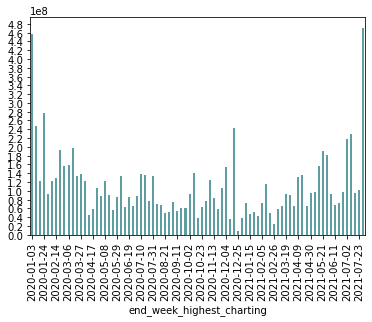

In [23]:
# Plot of `end_week_highest_charting`
final_df.groupby(['end_week_highest_charting'])['streams'].sum().plot(kind='bar', color='cadetblue')
plt.locator_params(nbins=30);

Compared to the bar plot made for end_week_highest_charting in [Part 1](./01_Data_Cleaning_and_EDA.ipynb), the chart above, has a decrease in peak of streams in the weeks '2020-12-18--2020-12-25' making it no longer an outlier. But, there is still strong peaks in '2020-01-03--2020-01-10' and '2021-07-23--2021-07-30'.

In [24]:
final_df[final_df['week_of_highest_charting'] == '2020-01-03--2020-01-10']

,index,highest_charting_position,number_of_times_charted,week_of_highest_charting,song_name,streams,artist,artist_followers,genre,release_date,weeks_charted,popularity,danceability,energy,loudness,speechiness,acousticness,liveness,tempo,duration_ms,valence,chord,start_week_highest_charting,end_week_highest_charting,contemporary,dance,edm,electropop,hip hop,house,indie,latin,other,pop,rap,reggaeton,rock,trap,danceability^2,danceability energy,danceability loudness,danceability speechiness,danceability acousticness,danceability liveness,danceability tempo,danceability valence,energy^2,energy loudness,energy speechiness,energy acousticness,energy liveness,energy tempo,energy valence,loudness^2,loudness speechiness,loudness acousticness,loudness liveness,loudness tempo,loudness valence,speechiness^2,speechiness acousticness,speechiness liveness,speechiness tempo,speechiness valence,acousticness^2,acousticness liveness,acousticness tempo,acousticness valence,liveness^2,liveness tempo,liveness valence,tempo^2,tempo valence,valence^2
146,146,59,83,2020-01-03--2020-01-10,Shallow,5672480.0,"Lady Gaga, Bradley Cooper",18572085.0,"['dance pop', 'pop', 'post-teen pop']",2018-10-05,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,83.0,0.572,0.385,-6.362,0.0308,0.37100,0.2310,95.799,215733.0,0.323,G,2020-01-03,2020-01-10,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0.327184,0.220220,-3.639064,0.017618,0.212212,0.132132,54.797028,0.184756,0.148225,-2.449370,0.011858,0.142835,0.088935,36.882615,0.124355,40.475044,-0.195950,-2.360302,-1.469622,-609.473238,-2.054926,0.000949,0.011427,0.007115,2.950609,0.009948,0.137641,0.085701,35.541429,0.119833,0.053361,22.129569,0.074613,9177.448401,30.943077,0.104329
212,212,20,82,2020-01-03--2020-01-10,Ride It,5235088.0,Regard,152226.0,"['dance pop', 'edm', 'pop dance', 'pop edm', '...",2019-07-26,2021-07-16--2021-07-23\n2021-07-09--2021-07-16...,84.0,0.880,0.751,-4.258,0.0874,0.17700,0.1060,117.948,157606.0,0.884,G,2020-01-03,2020-01-10,0,0,1,0,0,2,0,0,0,3,0,0,0,0,0.774400,0.660880,-3.747040,0.076912,0.155760,0.093280,103.794240,0.777920,0.564001,-3.197758,0.065637,0.132927,0.079606,88.578948,0.663884,18.130564,-0.372149,-0.753666,-0.451348,-502.222584,-3.764072,0.007639,0.015470,0.009264,10.308655,0.077262,0.031329,0.018762,20.876796,0.156468,0.011236,12.502488,0.093704,13911.730704,104.266032,0.781456
413,413,19,66,2020-01-03--2020-01-10,hot girl bummer,4992396.0,blackbear,4270131.0,"['electropop', 'pop', 'pop rap']",2020-08-21,2021-04-23--2021-04-30\n2021-04-16--2021-04-23...,83.0,0.782,0.559,-7.106,0.0767,0.12500,0.3850,129.992,188344.0,0.685,F#/Gb,2020-01-03,2020-01-10,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0.611524,0.437138,-5.556892,0.059979,0.097750,0.301070,101.653744,0.535670,0.312481,-3.972254,0.042875,0.069875,0.215215,72.665528,0.382915,50.495236,-0.545030,-0.888250,-2.735810,-923.723152,-4.867610,0.005883,0.009588,0.029530,9.970386,0.052540,0.015625,0.048125,16.249000,0.085625,0.148225,50.046920,0.263725,16897.920064,89.044520,0.469225
754,754,44,44,2020-01-03--2020-01-10,"10,000 Hours (with Justin Bieber)",4911749.0,Dan + Shay,2334615.0,"['contemporary country', 'country', 'pop']",2019-10-04,2020-11-20--2020-11-27\n2020-11-13--2020-11-20...,83.0,0.654,0.630,-4.644,0.0259,0.15300,0.1110,89.991,167693.0,0.430,A#/Bb,2020-01-03,2020-01-10,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0.427716,0.412020,-3.037176,0.016939,0.100062,0.072594,58.854114,0.281220,0.396900,-2.925720,0.016317,0.096390,0.069930,56.694330,0.270900,21.566736,-0.120280,-0.710532,-0.515484,-417.918204,-1.996920,0.000671,0.003963,0.002875,2.330767,0.011137,0.023409,0.016983,13.768623,0.065790,0.012321,9.989001,0.047730,8098.380081,38.696130,0.184900
800,800,105,26,2020-01-03--2020-01-10,Dancing With A Stranger (with Normani),5229835.0,Sam Smith,17097317.0,"['dance pop', 'pop', 'post-teen pop', 'uk pop']",2019-01-11,2020-10-30--2020-11-06\n2020-06-19--2020-06-26...,78.0,0.741,0.520,-7.513,0.0656,0.45000,0.2220,102.998,171030.0,0.347,G#/Ab,2020-01-03,2020-01-10,0,0,0,0,0,

In [25]:
final_df[final_df['week_of_highest_charting'] == '2021-07-23--2021-07-30']

,index,highest_charting_position,number_of_times_charted,week_of_highest_charting,song_name,streams,artist,artist_followers,genre,release_date,weeks_charted,popularity,danceability,energy,loudness,speechiness,acousticness,liveness,tempo,duration_ms,valence,chord,start_week_highest_charting,end_week_highest_charting,contemporary,dance,edm,electropop,hip hop,house,indie,latin,other,pop,rap,reggaeton,rock,trap,danceability^2,danceability energy,danceability loudness,danceability speechiness,danceability acousticness,danceability liveness,danceability tempo,danceability valence,energy^2,energy loudness,energy speechiness,energy acousticness,energy liveness,energy tempo,energy valence,loudness^2,loudness speechiness,loudness acousticness,loudness liveness,loudness tempo,loudness valence,speechiness^2,speechiness acousticness,speechiness liveness,speechiness tempo,speechiness valence,acousticness^2,acousticness liveness,acousticness tempo,acousticness valence,liveness^2,liveness tempo,liveness valence,tempo^2,tempo valence,valence^2
0,0,1,8,2021-07-23--2021-07-30,Beggin',48633449.0,Måneskin,3377762.0,"['indie rock italiano', 'italian pop']",2017-12-08,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,100.0,0.714,0.800,-4.808,0.0504,0.127000,0.3590,134.002,211560.0,0.589,B,2021-07-23,2021-07-30,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.509796,0.571200,-3.432912,0.035986,0.090678,0.256326,95.677428,0.420546,0.640000,-3.846400,0.040320,0.101600,0.287200,107.201600,0.471200,23.116864,-0.242323,-0.610616,-1.726072,-644.281616,-2.831912,0.002540,0.006401,0.018094,6.753701,0.029686,1.612900e-02,0.045593,17.018254,0.074803,0.128881,48.106718,0.211451,17956.536004,78.927178,0.346921
1,1,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),47248719.0,The Kid LAROI,2230022.0,['australian hip hop'],2021-07-09,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,99.0,0.591,0.764,-5.484,0.0483,0.038300,0.1030,169.928,141806.0,0.478,C#/Db,2021-07-23,2021-07-30,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.349281,0.451524,-3.241044,0.028545,0.022635,0.060873,100.427448,0.282498,0.583696,-4.189776,0.036901,0.029261,0.078692,129.824992,0.365192,30.074256,-0.264877,-0.210037,-0.564852,-931.885152,-2.621352,0.002333,0.001850,0.004975,8.207522,0.023087,1.466890e-03,0.003945,6.508242,0.018307,0.010609,17.502584,0.049234,28875.525184,81.225584,0.228484
4,4,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),33948454.0,Lil Nas X,5473565.0,"['lgbtq+ hip hop', 'pop rap']",2021-07-23,2021-07-23--2021-07-30,96.0,0.736,0.704,-7.409,0.0615,0.020300,0.0501,149.995,212000.0,0.894,D#/Eb,2021-07-23,2021-07-30,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0.541696,0.518144,-5.453024,0.045264,0.014941,0.036874,110.396320,0.657984,0.495616,-5.215936,0.043296,0.014291,0.035270,105.596480,0.629376,54.893281,-0.455653,-0.150403,-0.371191,-1111.312955,-6.623646,0.003782,0.001248,0.003081,9.224692,0.054981,4.120900e-04,0.001017,3.044898,0.018148,0.002510,7.514749,0.044789,22498.500025,134.095530,0.799236
19,19,20,7,2021-07-23--2021-07-30,Need To Know,16908917.0,Doja Cat,8640063.0,"['dance pop', 'pop']",2021-06-25,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,90.0,0.664,0.609,-6.509,0.0707,0.304000,0.0926,130.041,210560.0,0.194,C#/Db,2021-07-23,2021-07-30,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0.440896,0.404376,-4.321976,0.046945,0.201856,0.061486,86.347224,0.128816,0.370881,-3.963981,0.043056,0.185136,0.056393,79.194969,0.118146,42.367081,-0.460186,-1.978736,-0.602733,-846.436869,-1.262746,0.004998,0.021493,0.006547,9.193899,0.013716,9.241600e-02,0.028150,39.532464,0.058976,0.008575,12.041797,0.017964,16910.661681,25.227954,0.037636
21,21,22,5,2021-07-23--2021-07-30,Ain't Shit,16126897.0,Doja Cat,8640063.0,"['dance pop', 'pop']",2021-06-25,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,90.0,0.855,0.488,-4.601,0.2080,0.506000,0.3470,124.097,174253.0,0.619,D#/Eb,2021-07-23,2021-07-30,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0.731025,0.417240,-3.933855,0.177840,0.432630,0.296685,106.102935,0.529245,0.238144,-2.245288,0.101504,0.2469

Looking further into the weeks '2020-01-03--2020-01-10' and '2021-07-23--2021-07-30', there does not seem to be any outliers that are causing the peak in streams.

#### Release Date

To further look into categorical features such as `release_date`, I am going to split the year and day of week into new columns. Looking at the release day could be intuitive and have potential significane especially with a popular playlist called "New Music Friday" on Spotify. This curated playlist highlights new music every Friday and exposes people to songs and genres that may be different from their usual playlist. Because the playlist "highlight the songs that will probably get the most streams at the top, and work in a handful of songs into the top 30 that people might not have heard of, which are often independent — it’s important for us to serve both of those purposes [source](https://variety.com/2020/music/news/spotify-new-music-friday-playlist-1234843453/)," artists may have a higher chance of landing on Spotify's Top Hits based on day of release.

In [26]:
# Creating a Release Year and Release Day of Week Column
final_df['release_date_year'] = pd.DatetimeIndex(final_df['release_date']).year
final_df['release_date_day'] = pd.DatetimeIndex(final_df['release_date']).dayofweek

In [27]:
# Helper Function to Create Count Plots
def create_countplot(x_var, rotation_degree, title=''):
    fig, ax = plt.subplots(figsize = (10,6))
    plt.title(title, fontsize=15)
    plt.xticks(rotation=rotation_degree, fontsize=15)
    sns.countplot(x_var, ax=ax, palette='crest');

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


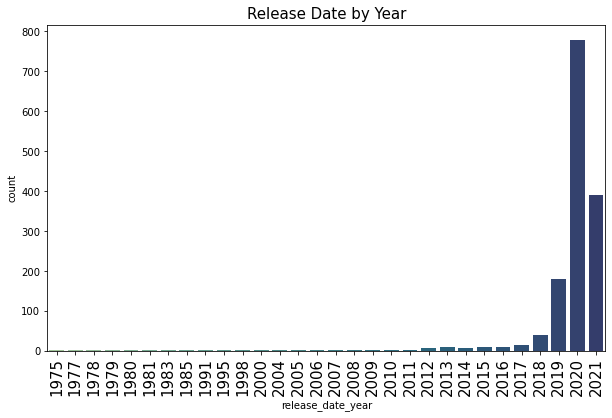

In [28]:
# Count Plot for Release Date by Year
create_countplot(final_df['release_date_year'], 90, 'Release Date by Year')

Based on the count plot above, most songs that were charted on Spotify's Top 200 Weekly (Global) charts from 2020 and 2021 were released in 2020 and 2021. This would make sense as the 2020 songs had more exposure compared to the 2021 songs. 

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


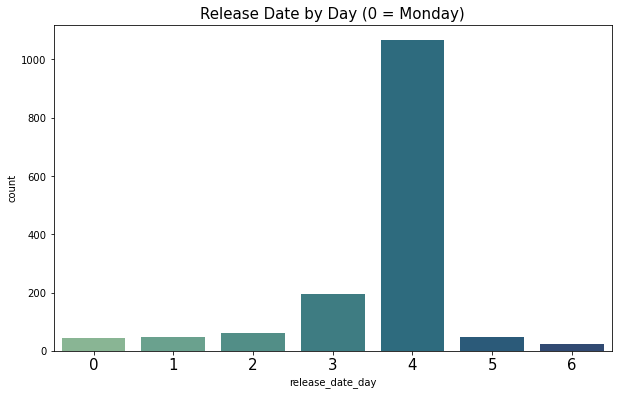

In [29]:
# Count Plot for Release Date by Day
create_countplot(final_df['release_date_day'], 0, 'Release Date by Day (0 = Monday)')

Based on the count plot above, most songs that were charted on Spotify's Top 200 Weekly (Global) charts from 2020 and 2021 were released on Friday. This makes sense as "the biggest reason a lot of major artists release music on Fridays is because of streaming and charting on the Billboard because they track sales from Friday to Thursday each week, so you are getting more sales by releasing on a Friday. Another reason a lot of artists release on Fridays is because of the streaming services’ editorial playlists [source](https://dailyrapfacts.com/22680/why-does-new-music-release-on-fridays/)."

In [30]:
# Dropping columns that won't be used in modeling
final_df.drop(['index', 'week_of_highest_charting', 'song_name', 'artist', 'genre', 'release_date', 'weeks_charted', 'start_week_highest_charting', 'end_week_highest_charting'], inplace = True, axis = 1)

In [31]:
# Dropping columns that won't be used in modeling
# This dataframe will only be used for initial modeling to get base scores
df.drop(['index', 'week_of_highest_charting', 'song_name', 'artist', 'genre', 'release_date', 'weeks_charted', 'start_week_highest_charting', 'end_week_highest_charting'], inplace = True, axis = 1)

In [32]:
final_df.shape

(1480, 67)

In [33]:
# df to CSV
df.to_csv('./datasets/spotify_2_df.csv', index=True)

In [34]:
# final_df to CSV
final_df.to_csv('./datasets/final_df.csv', index=True)

## Modeling

#### Linear Regression - Initial Features

In [35]:
# Defining X and y variables
X = df.drop(columns=['popularity', 'chord'])
y = df['popularity']

In [36]:
def linear_regression(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    lr = LinearRegression()
    lr_fit_train_test = lr.fit(X_train, y_train)
    
    #Baseline Score
    lr_fit = lr.fit(X, y)
    lr_score = lr.score(X, y)
    cross_val_xy = cross_val_score(lr, X, y)
    rmse_lr = mean_squared_error(y_true=y, y_pred=lr.predict(X), squared=False)
    
    #Train-Test Split
    cross_val = cross_val_score(lr, X_train, y_train)
    r2_train = lr.score(X_train, y_train)
    r2_test = lr.score(X_test, y_test)
    
    rmse_train = mean_squared_error(y_true=y_train, y_pred=lr.predict(X_train), squared=False)
    rmse_test = mean_squared_error(y_true=y_test, y_pred=lr.predict(X_test), squared=False)
    
    # Prediction and Residuals
    lr_preds = lr.predict(X_test)
    lr_residuals = lr_preds - y_test
   
    # Residuals Plot
    plt.scatter(lr_residuals.index, lr_residuals)
    plt.title("Residuals", fontsize = 15)
    plt.ylabel("Actual Values", fontsize = 15)
    plt.xlabel("Predicted Values", fontsize = 15)
    
    print(f'Linear Regression Train Cross Validation: {cross_val}')
    print(f'Linear Regression Train R^2: {r2_train}')
    print(f'Linear Regression Test R^2: {r2_test}')
    print(f'Root Mean Squared Error Train: {rmse_train}')
    print(f'Root Mean Squared Error Test: {rmse_test}')

Linear Regression Train Cross Validation: [0.08769186 0.11506275 0.08649097 0.14375067 0.13794373]
Linear Regression Train R^2: 0.15582742354850554
Linear Regression Test R^2: 0.14230489642133848
Root Mean Squared Error Train: 14.394187391496503
Root Mean Squared Error Test: 15.187025951822397


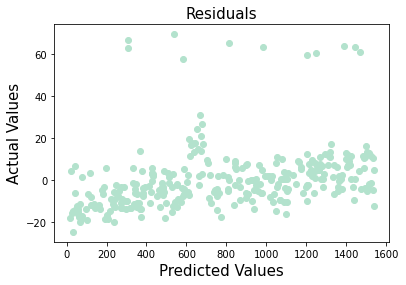

In [37]:
linear_regression(X, y)

I first did a linear regression model on all the initial features (before performing polynomial features and adding categorical columns). I got a very low train and test score and an RMSE train score of 14.39 and test score of 15.19.
These low scores make sense because of the LINE assumptions being violated. First, the X and y do not have a linear relationship as seen in the EDA done in [Part 1](./01_Data_Cleaning_and_EDA.ipynb). There also seems to be some outliers towards 60 on the y axis when looking at the residual plot.

#### Utilizing Pipelines with Initial Features

Because I found that the linear regression model did not seem fit for this problem, I decided to use decision trees, random forest, and extratrees. I first decided a decision tree would be best because it is non-parametric and we don't make assumptions about how our data or errors are distributed. Because random forest select at each split a random subset of features, using random forest may help with overfitting from the decision tree.

In [38]:
# Create Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [39]:
# Instantiate Pipelines
random_state = 42
pipe_lr = Pipeline([('ss', StandardScaler()), #Linear Regression
('lr', LinearRegression())])

pipe_dt = Pipeline([('ss', StandardScaler()),
('dt', DecisionTreeRegressor(random_state=random_state))]) #Decision Tree

pipe_rf = Pipeline([('ss', StandardScaler()),
                  ('rf', RandomForestRegressor(random_state=random_state))]) #Random Forest

In [40]:
# Fitting Pipelines
pipe_lr.fit(X_train, y_train)
pipe_dt.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('rf', RandomForestRegressor(random_state=42))])

In [41]:
# Train and Test RMSE Score for Each Pipeline
model_list = [pipe_lr, pipe_dt, pipe_rf]
for model in model_list:
    print (model[1])
    print (f'RMSE Train Score: {mean_squared_error(y_train, model.predict(X_train), squared = False)}')
    print (f'RMSE Test Score: {mean_squared_error(y_test, model.predict(X_test), squared = False)}')
    print ('')
    print (model[1])
    print (f'R2 Train Score: {model.score(X_train, y_train)}')
    print (f'R2 Test Score: {model.score(X_test, y_test)}')
    print ('')

LinearRegression()
RMSE Train Score: 14.370784838435798
RMSE Test Score: 15.38537103442241

LinearRegression()
R2 Train Score: 0.15857016034354288
R2 Test Score: 0.11975531997747058

DecisionTreeRegressor(random_state=42)
RMSE Train Score: 0.0
RMSE Test Score: 12.90718672893762

DecisionTreeRegressor(random_state=42)
R2 Train Score: 1.0
R2 Test Score: 0.38048668245357553

RandomForestRegressor(random_state=42)
RMSE Train Score: 3.475808525064725
RMSE Test Score: 8.28822750715471

RandomForestRegressor(random_state=42)
R2 Train Score: 0.950776938330908
R2 Test Score: 0.7445471289944596



Looking at the above R2 scores for each model ran on the initial features, the random forest regressor seems to be performing the best, but is overfit. The decision tree is highly overfit when compared to the random forest model.

In [42]:
# Helper Function for R2 Scores
def train_test_score(model):
    print(f'Train Score: {model.score(X_train, y_train)}')
    print(f'Test Score: {model.score(X_test, y_test)}')     

In [43]:
# Helper Function for RMSE
def rmse(model):
    print(f'RMSE Train Score: {mean_squared_error(y_train, model.predict(X_train), squared = False)}')
    print(f'RMSE Test Score: {mean_squared_error(y_test, model.predict(X_test), squared = False)}') 

#### Decision Tree Gridsearch

After runnning initial baseline tests on the linear regression, decision tree, and random forest, I decided to run a gridsearch on the decision tree and random forest.

Further details and code on the Gridsearch and parameters used can be seen [here](./gridsearch_summary.ipynb).

In [44]:
# Instantiate Decision Tree
pipe_dt_gs_results = Pipeline([('ss', StandardScaler()),
('dt', DecisionTreeRegressor(random_state=random_state,
        max_depth=6, max_features='auto', max_leaf_nodes=20,
        min_samples_leaf=8))])

In [45]:
# Fit Decision Tree
pipe_dt_gs_results.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('dt',
                 DecisionTreeRegressor(max_depth=6, max_features='auto',
                                       max_leaf_nodes=20, min_samples_leaf=8,
                                       random_state=42))])

In [46]:
# R2 Train and Test Score
train_test_score(pipe_dt_gs_results)

Train Score: 0.7247727412899578
Test Score: 0.7110139742308969


In [47]:
# RMSE Train and Test Score
rmse(pipe_dt_gs_results)

RMSE Train Score: 8.218967340435844
RMSE Test Score: 8.815454149189414


The decision tree gridsearch improved the overfitting in the initial decision tree model created above. Although the gridsearch helped with overfitting, the model train and test score does not meet the intended goal of at least 10% increase on the test score and a RMSE (popularity) score. The hyperparameters chosen, max_depth = 6 represents the number of max splits (seen below in the decision tree plot), the max_features chosen was auto which means there are no restrictions to how many features. The maximum leaf nodes is 20 and the minimum sample leaf is 8.


In [48]:
pipe_dt_gs_results.feature_names = list(X_train.columns.values)

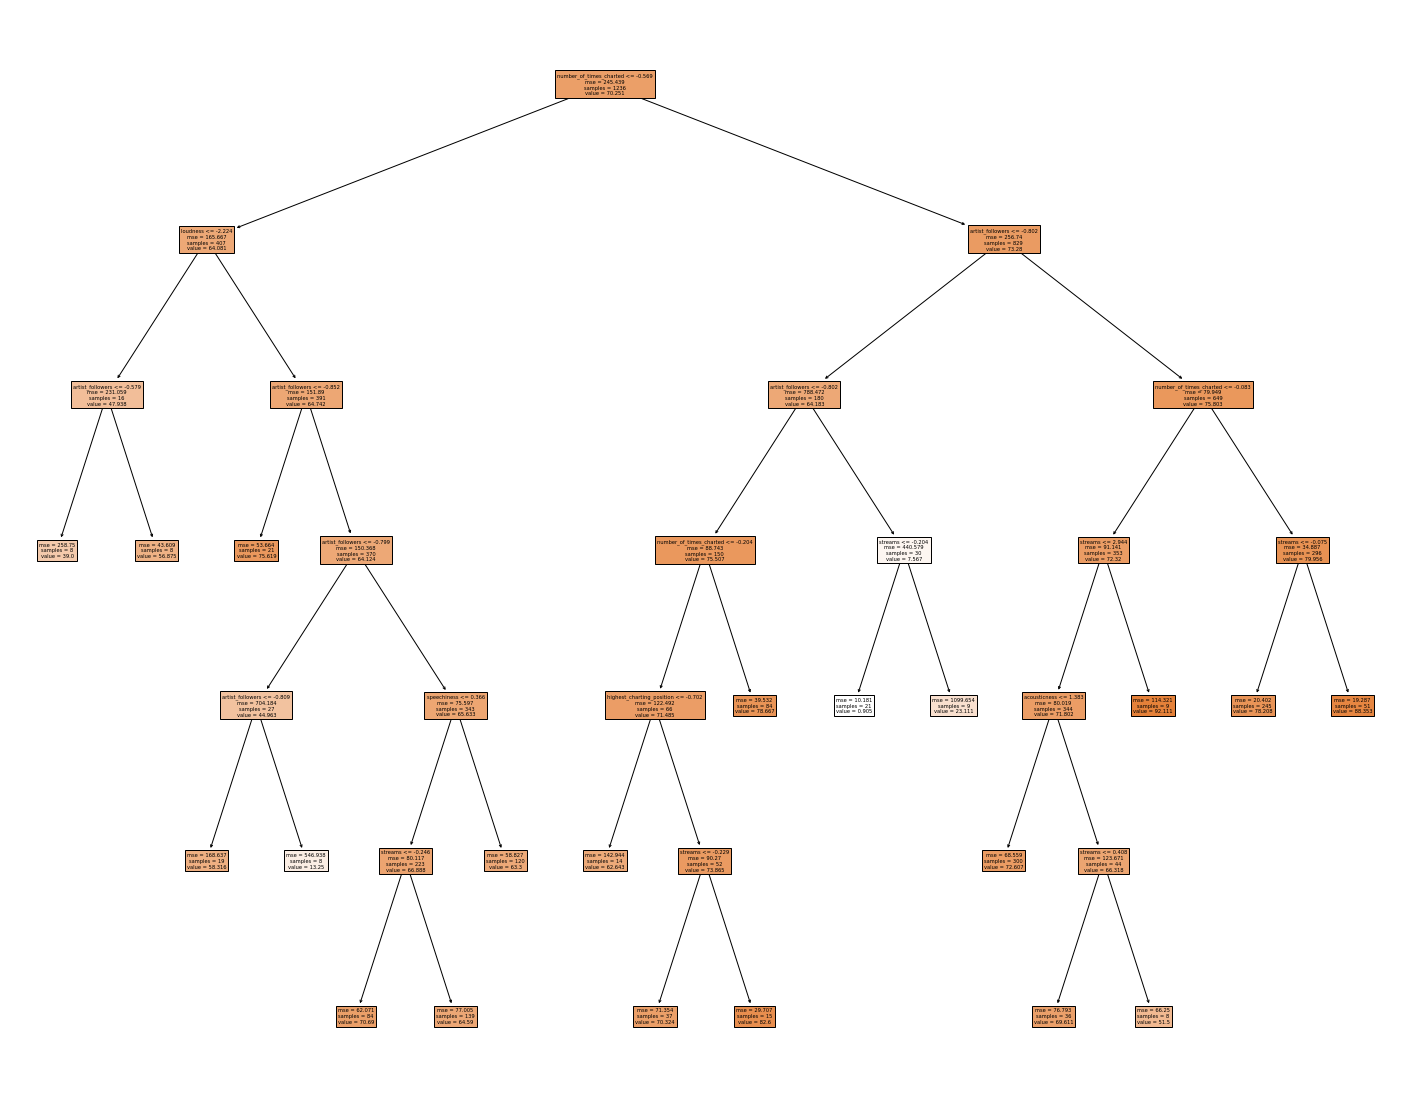

In [49]:
# Plotting Decision Tree
fig = plt.figure(figsize=(25,20))
plot_tree(pipe_dt_gs_results['dt'], feature_names=pipe_dt_gs_results.feature_names,
          class_names= df['popularity'],
         filled=True);

#### Random Forest Decision Tree

After running a gridsearch on the decision tree, I ran a random forest gridsearch. With a baseline R2 score of train 0.951 and test 0.744 and a baseline RMSE of train 3.47 and test 8.28, I knew my main goal for random forest was to prune the tree and combat overfitting. Further details and code on the Gridsearch and parameters used can be seen [here](./gridsearch_summary.ipynb).

In [50]:
# Instantiate Random Forest Pipeline
pipe_rf_gs_results = Pipeline([('ss', StandardScaler()),
                  ('rf', RandomForestRegressor(random_state=random_state,
                max_depth=30, max_features='auto', min_samples_leaf=2, min_samples_split=5,
                n_estimators=200))])

In [51]:
# Fit Pipeline
pipe_rf_gs_results.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('rf',
                 RandomForestRegressor(max_depth=30, min_samples_leaf=2,
                                       min_samples_split=5, n_estimators=200,
                                       random_state=42))])

In [52]:
# R2 Train and Test Score
train_test_score(pipe_rf_gs_results)

Train Score: 0.9229451683854085
Test Score: 0.7552469386460638


In [53]:
# RMSE Train and Test Score
rmse(pipe_rf_gs_results)

RMSE Train Score: 4.3488203799551055
RMSE Test Score: 8.112791898226124


Overall, this gridsearch only so slightly helped with the overfitting compared to the baseline model, as the train test decreased.

#### ExtraTrees

In [54]:
# Instantiate ExtraTrees Pipeline
pipe_xt_gs_results = Pipeline([('ss', StandardScaler()),
                    ('xt', ExtraTreesRegressor(random_state=random_state,
                    max_depth=30, max_features=None, min_samples_leaf=1,
                    min_samples_split=2, n_estimators=200))])

In [55]:
# Fit Pipeline
pipe_xt_gs_results.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('xt',
                 ExtraTreesRegressor(max_depth=30, max_features=None,
                                     n_estimators=200, random_state=42))])

In [56]:
# R2 Train and Test Score
train_test_score(pipe_xt_gs_results)

Train Score: 0.9999998711682616
Test Score: 0.6687534914969226


In [57]:
# RMSE Train and Test Score
rmse(pipe_xt_gs_results)

RMSE Train Score: 0.005623192691697185
RMSE Test Score: 9.438042405968314


I also ran a gridsearch on ExtraTrees, but due to its high overfitting problem, I will focus on improving the random forest model.

#### Adding in Polynomial Features to the Model

In [58]:
# Define X
X_poly = final_df.drop(['popularity', 'chord', 'release_date_day', 'release_date_year'], axis='columns')
# Define y
y = final_df['popularity']

In [59]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, train_size=0.8, random_state=42)

In [60]:
# Instantiate Pipeline
pipe_rf_poly = Pipeline([('ss', StandardScaler()),
                  ('rf', RandomForestRegressor(random_state=random_state))])

In [61]:
# Fit Pipeline
pipe_rf_poly.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('rf', RandomForestRegressor(random_state=42))])

In [62]:
# R2 Train and Test Score
train_test_score(pipe_rf_poly)

Train Score: 0.9548908560267945
Test Score: 0.7621856823207609


In [63]:
# RMSE Train and Test Score
rmse(pipe_rf_poly)

RMSE Train Score: 3.173712337310992
RMSE Test Score: 7.154036306377889


In [64]:
cross_val_score(pipe_rf_poly, X_poly, y, cv=5)

array([0.32854283, 0.61759744, 0.70334828, 0.67760622, 0.48486442])

Adding in all the polynomial features to the random forest model gave a R2 score of 0.955 (train) and 0.762 (test) and an RMSE train score of 3.17 and test score of 7.15. Adding all the polynomial features to the model increased the test score by ~2% and slightly decreased the RMSE test score.

Next, I decided to take out some polynomial features and only add in the ones that I found had a normal distribution.

In [65]:
# Define X
X_poly_2 = final_df[['highest_charting_position', 'number_of_times_charted',
       'streams', 'duration_ms',
       'artist_followers','danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'liveness', 'tempo', 'valence',
       'contemporary', 'dance', 'edm', 'electropop', 'hip hop', 'house',
       'indie', 'latin', 'other', 'pop', 'rap', 'reggaeton', 'rock', 'trap',
       'danceability^2', 'danceability energy', 'energy^2', 'energy loudness', 'energy tempo']]

# Define y
y = final_df['popularity']

In [66]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_poly_2, y, train_size=0.8, random_state=42)

In [67]:
# Instantiate Random Forest Pipeline
pipe_rf_poly_2 = Pipeline([('ss', StandardScaler()),
                  ('rf', RandomForestRegressor(random_state=random_state))])

In [68]:
# Fit Random Forest
pipe_rf_poly_2.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('rf', RandomForestRegressor(random_state=42))])

In [69]:
# R2 Train and Test Score
train_test_score(pipe_rf_poly_2)

Train Score: 0.9619582059325126
Test Score: 0.7941846002626549


In [70]:
# RMSE Train and Test Score
rmse(pipe_rf_poly_2)

RMSE Train Score: 2.914511426999062
RMSE Test Score: 6.655352677113119


In [71]:
cross_val_score(pipe_rf_poly_2, X_train, y_train, cv=5)

array([0.64824299, 0.66654937, 0.76043815, 0.76907682, 0.68941977])

By doing this, I got a slight increase in the R2 test score along with lower RMSE train and test score specifically, when compared to the model with all the polynomial features included.

#### Adding `chord` Column

In [72]:
# Adding/Dummifying `Chord`
X_poly_chord = final_df[['highest_charting_position', 'number_of_times_charted',
       'streams',
       'artist_followers','danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'liveness', 'tempo', 'valence',
       'contemporary', 'dance', 'edm', 'electropop', 'hip hop', 'house',
       'indie', 'latin', 'other', 'pop', 'rap', 'reggaeton', 'rock', 'trap',
       'danceability^2', 'danceability energy', 'energy^2', 'energy loudness', 'energy tempo', 'chord'
        ]]
X = pd.get_dummies(columns=['chord'], drop_first=True, data=X_poly_chord)

In [73]:
X.head()

,highest_charting_position,number_of_times_charted,streams,artist_followers,danceability,energy,loudness,speechiness,acousticness,liveness,tempo,valence,contemporary,dance,edm,electropop,hip hop,house,indie,latin,other,pop,rap,reggaeton,rock,trap,danceability^2,danceability energy,energy^2,energy loudness,energy tempo,chord_A#/Bb,chord_B,chord_C,chord_C#/Db,chord_D,chord_D#/Eb,chord_E,chord_F,chord_F#/Gb,chord_G,chord_G#/Ab
0,1,8,48633449.0,3377762.0,0.714,0.800,-4.808,0.0504,0.1270,0.3590,134.002,0.589,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.509796,0.571200,0.640000,-3.846400,107.201600,0,1,0,0,0,0,0,0,0,0,0
1,2,3,47248719.0,2230022.0,0.591,0.764,-5.484,0.0483,0.0383,0.1030,169.928,0.478,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.349281,0.451524,0.583696,-4.189776,129.824992,0,0,0,1,0,0,0,0,0,0,0
2,1,11,40162559.0,6266514.0,0.563,0.664,-5.044,0.1540,0.3350,0.0849,166.928,0.688,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.316969,0.373832,0.440896,-3.349216,110.840192,0,0,0,0,0,0,0,0,0,0,0
3,3,5,37799456.0,83293380.0,0.808,0.897,-3.712,0.0348,0.0469,0.3640,126.026,0.591,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0.652864,0.724776,0.804609,-3.329664,113.045322,0,1,0,0,0,0,0,0,0,0,0
4,5,1,33948454.0,5473565.0,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,0.894,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0.541696,0.518144,0.495616,-5.215936,105.596480,0,0,0,0,0,1,0,0,0,0,0


In [74]:
# Define y
y = final_df['popularity']

In [75]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [76]:
# Instantiate Random Forest Pipeline
pipe_rf_chord = Pipeline([('ss', StandardScaler()),
                  ('rf', RandomForestRegressor(random_state=42))])

In [77]:
# Fit Random Forest
pipe_rf_chord.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('rf', RandomForestRegressor(random_state=42))])

In [78]:
# R2 Train and Test Score
train_test_score(pipe_rf_chord)

Train Score: 0.9615551725686685
Test Score: 0.7990411576121005


In [79]:
# RMSE Train and Test Score
rmse(pipe_rf_chord)

RMSE Train Score: 2.929909629867309
RMSE Test Score: 6.5763618464265745


In [80]:
cross_val_score(pipe_rf_chord, X_train, y_train, cv=5)

array([0.64664619, 0.64982563, 0.7736561 , 0.75812469, 0.71778871])

Comparing the model prior to this one, by adding `chord`, the model had a very slight increase in R2 and decrease in RMSE score.

#### Adding `release_date_day` & `release_date_year`

In [81]:
# Define X
X_release = final_df[['highest_charting_position', 'number_of_times_charted',
       'streams',
       'artist_followers','danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'liveness', 'tempo', 'valence',
       'contemporary', 'dance', 'edm', 'electropop', 'hip hop', 'house',
       'indie', 'latin', 'other', 'pop', 'rap', 'reggaeton', 'rock', 'trap',
       'danceability^2', 'danceability energy', 'energy^2', 'energy loudness', 'energy tempo', 'chord', 
       'release_date_day', 'release_date_year']]

# Dummify `chord`
X = pd.get_dummies(columns=['chord'], drop_first=True, data=X_release)

In [82]:
X.head()

,highest_charting_position,number_of_times_charted,streams,artist_followers,danceability,energy,loudness,speechiness,acousticness,liveness,tempo,valence,contemporary,dance,edm,electropop,hip hop,house,indie,latin,other,pop,rap,reggaeton,rock,trap,danceability^2,danceability energy,energy^2,energy loudness,energy tempo,release_date_day,release_date_year,chord_A#/Bb,chord_B,chord_C,chord_C#/Db,chord_D,chord_D#/Eb,chord_E,chord_F,chord_F#/Gb,chord_G,chord_G#/Ab
0,1,8,48633449.0,3377762.0,0.714,0.800,-4.808,0.0504,0.1270,0.3590,134.002,0.589,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.509796,0.571200,0.640000,-3.846400,107.201600,4,2017,0,1,0,0,0,0,0,0,0,0,0
1,2,3,47248719.0,2230022.0,0.591,0.764,-5.484,0.0483,0.0383,0.1030,169.928,0.478,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.349281,0.451524,0.583696,-4.189776,129.824992,4,2021,0,0,0,1,0,0,0,0,0,0,0
2,1,11,40162559.0,6266514.0,0.563,0.664,-5.044,0.1540,0.3350,0.0849,166.928,0.688,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.316969,0.373832,0.440896,-3.349216,110.840192,4,2021,0,0,0,0,0,0,0,0,0,0,0
3,3,5,37799456.0,83293380.0,0.808,0.897,-3.712,0.0348,0.0469,0.3640,126.026,0.591,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0.652864,0.724776,0.804609,-3.329664,113.045322,4,2021,0,1,0,0,0,0,0,0,0,0,0
4,5,1,33948454.0,5473565.0,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,0.894,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0.541696,0.518144,0.495616,-5.215936,105.596480,4,2021,0,0,0,0,0,1,0,0,0,0,0


In [83]:
# Define Y
y = final_df['popularity']

In [84]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [85]:
# Instantiate Random Forest Pipeline
pipe_rf_release = Pipeline([('ss', StandardScaler()),
                  ('rf', RandomForestRegressor(random_state=42))])

In [86]:
# Fit Random Forest Pipeline
pipe_rf_release.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('rf', RandomForestRegressor(random_state=42))])

In [87]:
# R2 Train and Test Score
train_test_score(pipe_rf_release)

Train Score: 0.9723060547550217
Test Score: 0.8683992286559993


In [88]:
# RMSE Train and Test Score
rmse(pipe_rf_release)

RMSE Train Score: 2.486724549781597
RMSE Test Score: 5.321834422604824


In [89]:
cross_val_score(pipe_rf_release, X_train, y_train, cv=5)

array([0.69971567, 0.69912423, 0.78396772, 0.8223514 , 0.74658998])

By adding the `release_date_day` and `release_date_year` the model train score went up by ~0.07 and there is less overfitting when compared to the prior model (pipe_rf_chord).

#### Utilizing LASSO to Check Coefficients

 Even though the linear regression model performed poorly, I decided to utilize LASSO to further look into the coefficients. I also want to make sure that I am not creating noise when adding the polynomial features, chord, and release day/year, as there were only slight improvements on some of the models.

In [90]:
# Instantiate Linear Regression Pipeline with LASSO
pipe_ls = Pipeline([('ss', StandardScaler()),
('ls', LassoCV(random_state=random_state))])

In [91]:
# Fit Pipeline
pipe_ls.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('ls', LassoCV(random_state=42))])

In [92]:
# R2 Train and Test Score
train_test_score(pipe_ls)

Train Score: 0.17264582421165042
Test Score: 0.1317153743766848


In [93]:
# Coefficients after running LASSO
pipe_ls['ls'].coef_

array([-0.8934248 ,  2.38774134,  2.79387829,  0.01039604, -0.15426042,
       -0.        ,  1.09731603, -0.27559734,  0.        , -0.        ,
       -0.039515  ,  0.06778712,  0.58682974,  0.        ,  0.07529431,
        0.34630416,  0.03393009,  0.51722145,  0.2657332 ,  0.30787314,
        1.54728192,  2.33296477,  1.35602254,  1.1418033 ,  0.45027183,
        0.80892389, -0.00879506, -0.        , -0.        , -0.02550049,
       -0.        , -0.        , -1.0223549 , -0.        , -0.27152619,
       -0.25555489, -0.        ,  0.        ,  0.3273851 ,  0.        ,
        0.01321018,  0.07184071,  0.19170029, -0.12267482])

In [94]:
# Dataframe to show coefficients after running LASSO
coef_df = pd.DataFrame(data = pipe_ls['ls'].coef_, index = X.columns, columns = ['feature'])

coef_df.loc[abs(coef_df['feature']) == 0]

,feature
energy,-0.0
acousticness,0.0
liveness,-0.0
dance,0.0
danceability energy,-0.0
energy^2,-0.0
energy tempo,-0.0
release_date_day,-0.0
chord_A#/Bb,-0.0
chord_C#/Db,-0.0


After looking at the coefficients, I took out features that had +/- 0.00 coefficients and ended up with the features below.

In [95]:
# Define X
X = final_df[['highest_charting_position', 'number_of_times_charted',
       'streams',
       'artist_followers', 'loudness', 'speechiness',
       'tempo', 'valence',
       'contemporary', 'edm', 'electropop', 'hip hop', 'house',
       'indie', 'latin', 'other', 'pop', 'rap', 'reggaeton', 'rock', 'trap',
       'danceability^2', 'energy loudness', 'chord', 
       'release_date_year']]

# Dummify `chord`              
X = pd.get_dummies(columns=['chord'], drop_first=True, data=X)
# Drop chords with 0 coefficient
X = X.drop(columns=['chord_A#/Bb', 'chord_C#/Db', 'chord_D', 'chord_E'])

In [96]:
# Define y
y = final_df['popularity']

In [97]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [98]:
# Instantiate Random Forest Pipeline
pipe_rf_coefs = Pipeline([('ss', StandardScaler()),
                  ('rf', RandomForestRegressor(random_state=random_state))])

In [99]:
# Fit Random Forest Pipeline
pipe_rf_coefs.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('rf', RandomForestRegressor(random_state=42))])

In [100]:
# R2 Train and Test Score
train_test_score(pipe_rf_coefs)

Train Score: 0.9724188383874857
Test Score: 0.8719100727999521


In [101]:
# RMSE Train and Test Score
rmse(pipe_rf_coefs)

RMSE Train Score: 2.4816557892022577
RMSE Test Score: 5.250366621690542


In [102]:
cross_val_score(pipe_rf_coefs, X_train, y_train, cv=5)

array([0.76506213, 0.72466422, 0.80390277, 0.823026  , 0.77131467])

I found that this combination of features from utilizing LASSO to help eliminate certain features based on zeroing out coefficients has reduced the overfitting seen in the other models. Next, I will run a gridsearch on these features to see if I can futher reduce the overfitting.

#### Gridsearch with Chosen Features from Polynomial and Categorical Features

In [103]:
# Instantiate Random Forest Pipeline 
pipe_rf_gs_results_2 = Pipeline([('ss', StandardScaler()),
                  ('rf', RandomForestRegressor(random_state=random_state,
                max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=2,
                n_estimators=200))])

In [104]:
# Fit Random Forest Pipeline
pipe_rf_gs_results_2.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('rf',
                 RandomForestRegressor(max_depth=30, max_features=None,
                                       min_samples_leaf=4, n_estimators=200,
                                       random_state=42))])

In [105]:
# R2 Train and Test Score
train_test_score(pipe_rf_gs_results_2)

Train Score: 0.9029516161708429
Test Score: 0.8484534126944556


In [106]:
# RMSE Train and Test Score
rmse(pipe_rf_gs_results_2)

RMSE Train Score: 4.65510435299805
RMSE Test Score: 5.710908754723886


Utilizing gridserach to tune the hyperparameters, the random forest model went from having a train score of 0.972 and a test score of 0.867 to having a a train score of 0.903 and test score of 0.849. Tuning the hyperparameters reduced the overfitting between the train and test score.

In [107]:
model_importance = pipe_rf_gs_results_2.named_steps['rf'].feature_importances_

In [108]:
# Feature Importances to DF
feature_importance = pd.DataFrame(data =  pipe_rf_gs_results_2.named_steps['rf'].feature_importances_, index = X.columns, columns = ['feature'])
feature_importance.sort_values(by="feature", ascending=False)

,feature
artist_followers,0.575153
number_of_times_charted,0.140162
streams,0.083920
release_date_year,0.064529
loudness,0.038240
highest_charting_position,0.016692
danceability^2,0.014315
energy loudness,0.014116
speechiness,0.012670
tempo,0.012359


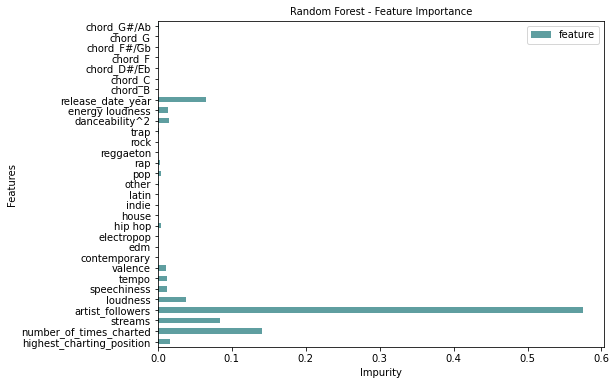

In [109]:
# Plot Feature Importance
feature_importance.plot.barh(color='cadetblue',
                        figsize=(8,6))
plt.title('Random Forest - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Impurity')
plt.show();

Looking at the feature importance, `artist_followers`, `number_of_times_charted`, `streams`, and `release_date_year` have the highest gain in loss of impurity.

In [110]:
# Define X
X_fi = final_df[['highest_charting_position', 'number_of_times_charted',
       'streams',
       'artist_followers', 'loudness', 'speechiness',
       'tempo', 'valence',
       'danceability^2', 'energy loudness', 
       'release_date_year', 'rap', 'pop', 'hip hop']]
              

In [111]:
# Define Y
y_fi = final_df['popularity']

In [112]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_fi, y_fi, train_size=0.8, random_state=42)

In [113]:
# Instantiate Random Forest
pipe_rf_fi = Pipeline([('ss', StandardScaler()),
                  ('rf', RandomForestRegressor(random_state=random_state,
                max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=2,
                n_estimators=200))])

In [114]:
# Fit Random Forest Model
pipe_rf_fi.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('rf',
                 RandomForestRegressor(max_depth=30, max_features=None,
                                       min_samples_leaf=4, n_estimators=200,
                                       random_state=42))])

In [115]:
# R2 Train and Test Score
train_test_score(pipe_rf_fi)

Train Score: 0.9027368913712408
Test Score: 0.8464927282511611


In [119]:
# RMSE Train and Test Score
rmse(pipe_rf_fi)

RMSE Train Score: 4.6602513426853855
RMSE Test Score: 5.747733421621051


By only using the features that were above 0 in impurity from the features importance, we see there is a small and slight increase in the train and test score. 

In [116]:
estimator = pipe_rf_gs_results_2.named_steps['rf'].estimators_

In [117]:
pipe_rf_gs_results_2.feature_names = list(X_train.columns.values)

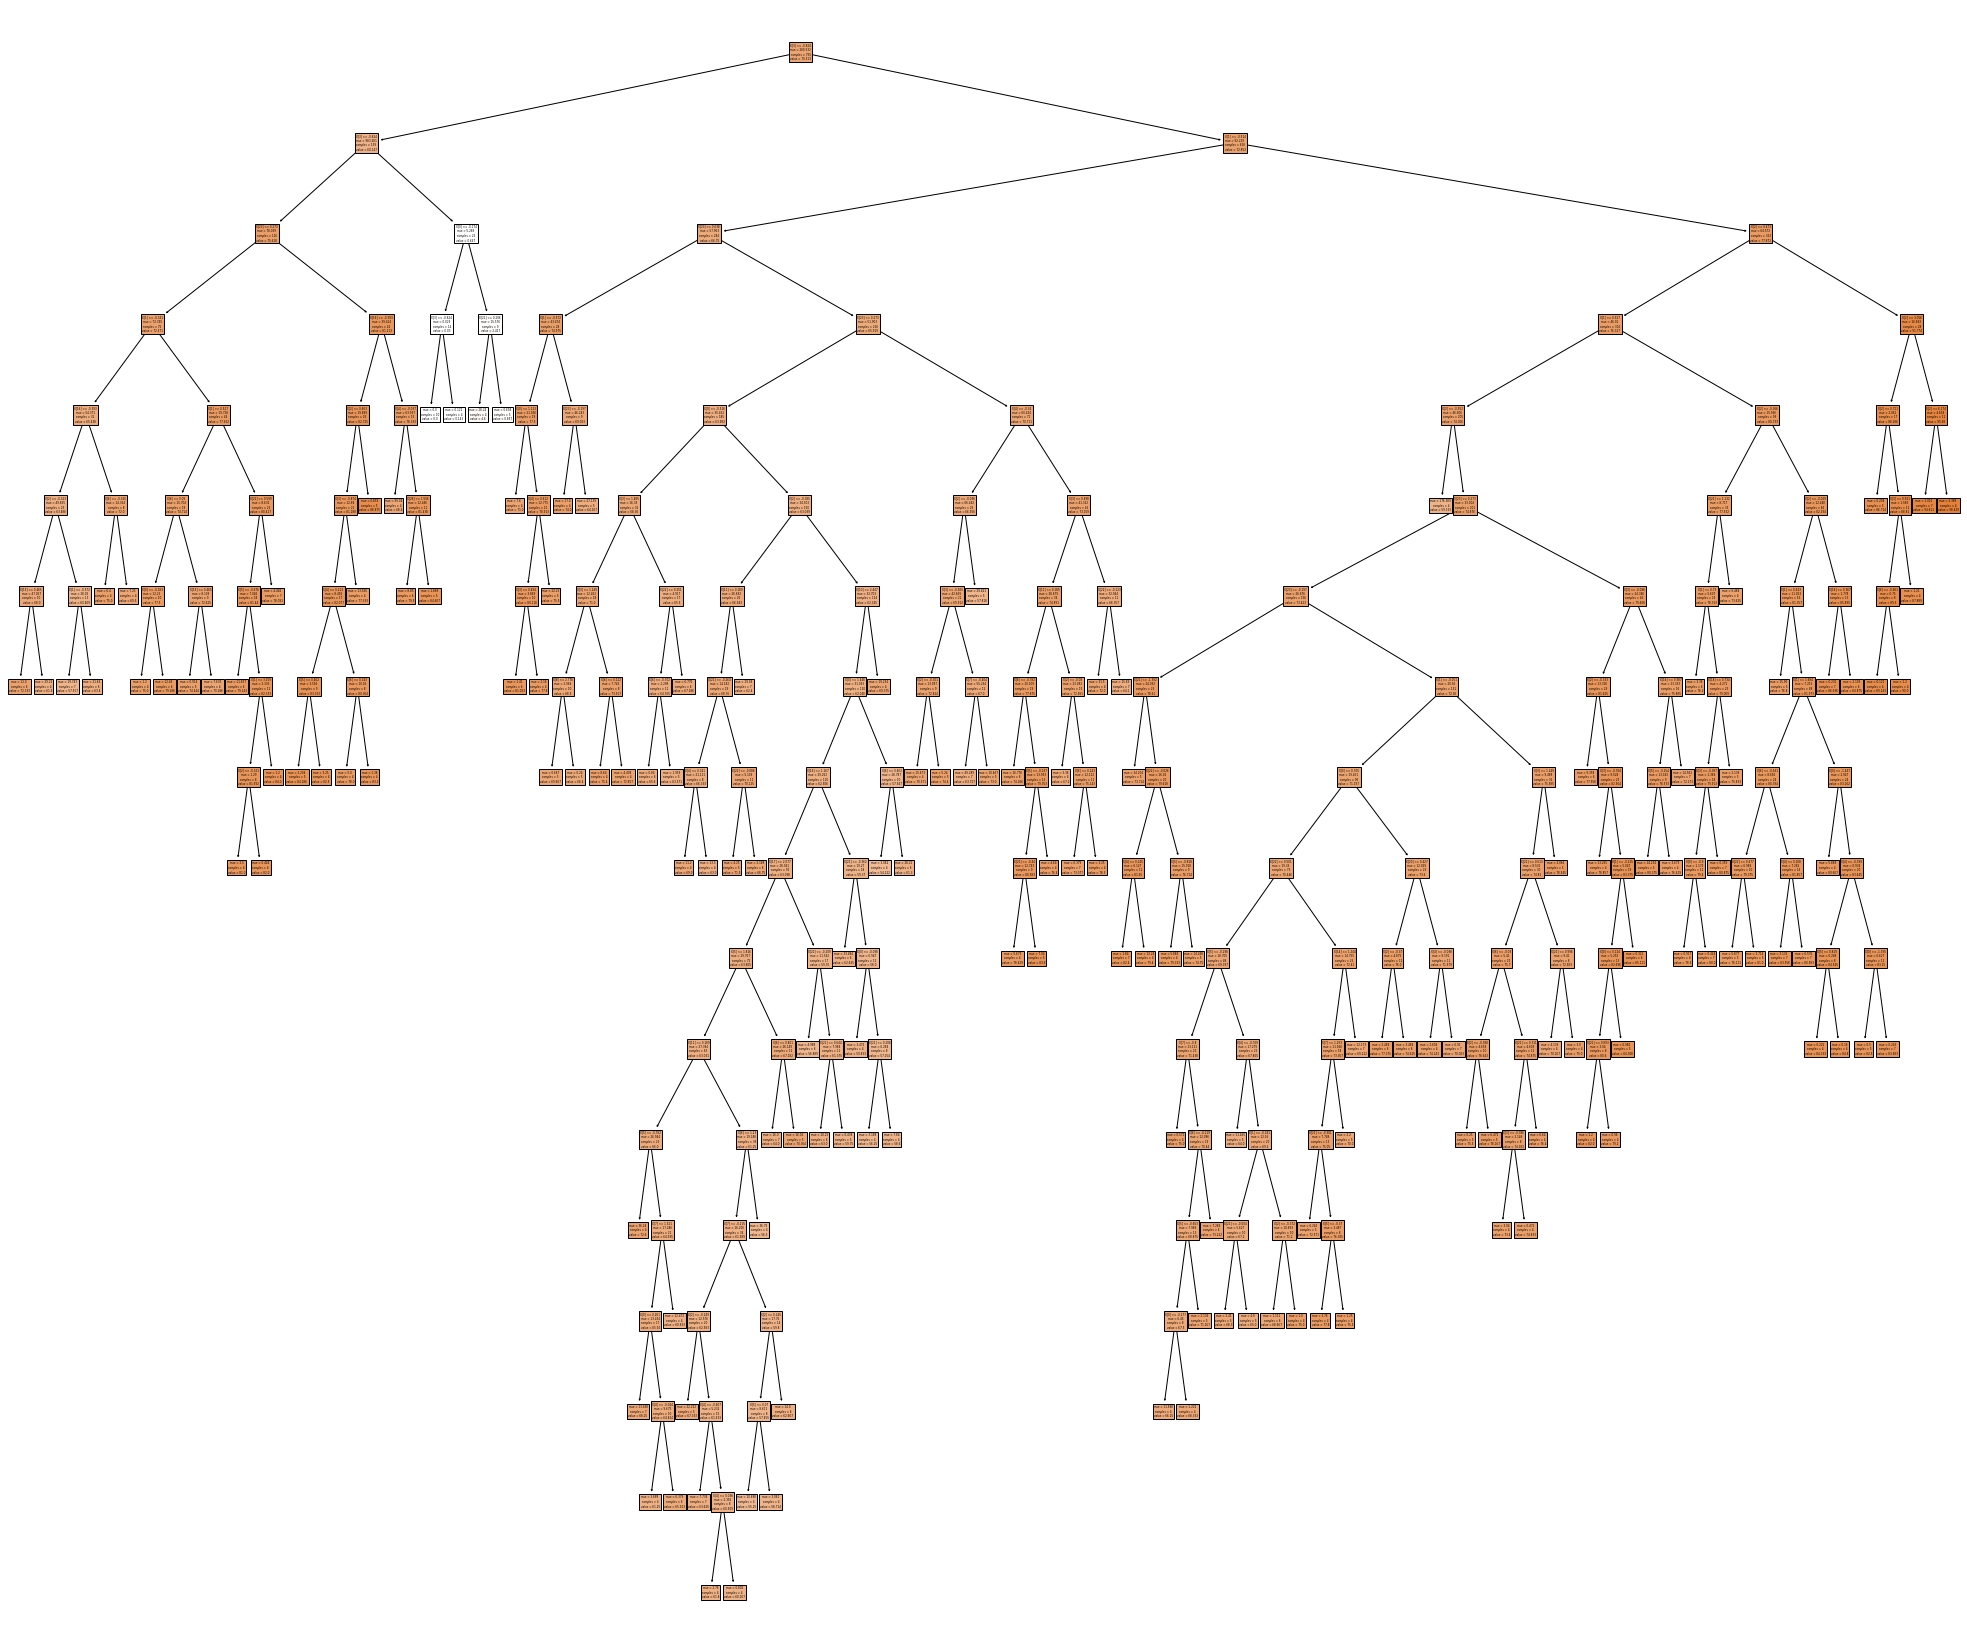

In [118]:
fig = plt.figure(figsize=(35,30))
tree.plot_tree(pipe_rf_gs_results_2.named_steps['rf'].estimators_[0],
               filled=True);

### Model Performance on Training/Test Data
|Model|Train Score|Test Score|
|---|---|---|
|Baseline: Linear Regression|0.159|0.119|
|Baseline: Decision Tree|1.0|0.380|
|Baseline: Random Forest|0.951|0.744|
|Decision Tree: Gridsearch|0.725|0.711|
|Random Forest: Gridsearch|0.923|0.755|

### Model Performance on Training/Test Data - Random Forest
|Model|Train Score|Test Score|
|---|---|---|
|Random Forest: Polynomial Features|0.962|0.794|
|Random Forest: Chord|0.962|0.799|
|Random Forest: Release Date/Year|0.972|0.868|
|Random Forest: After LASSO|0.972|0.872|
|Random Forest: Final Features & Gridsearch|0.903|0.848|

### Train/Test RMSE (Baseline Models)
|Model|Train Score|Test Score|
|---|---|---|
|Baseline: Linear Regression|14.37|15.39|
|Baseline: Decision Tree|0.0|12.91|
|Baseline: Random Forest|3.48|8.29|
|Decision Tree: Gridsearch|8.22|8.82|
|Random Forest: Gridsearch|4.35|8.11|

### Train/Test RMSE
|Model|Train Score|Test Score|
|---|---|---|
|Random Forest: Polynomial Features|2.91|6.66|
|Random Forest: Chord|2.93|6.58|
|Random Forest: Release Date/Year|2.49|5.32|
|Random Forest: After LASSO|2.48|5.25|
|Random Forest: Final Features & Gridsearch|4.65|5.71|

### Conclusion

Overall, by doing data cleaning on the genres and taking the 335 various genres and creating 14 larger "family" genres to group the 335 genres in, using polynomial features, and creating dummified columns from catergorical features, I was able to create a model to predict the popularity score of a song on Spotify.

With the goal of improving the RMSE and R2 score of at least 10%, I was able to achieve a train RMSE score of 4.65 and a test RMSE 5.71 and a R2 train score of 0.903 and R2 test score of 0.848. The RMSE was improved by ~30% and the R2 test score was improved by ~14% (Baseline random forest model had a R2 train score of 0.951, test score of 0.745, RMSE train of 3.47, and RMSE test of 8.28). This was achieved through a random forest regressor model. Looking at the attribute, feature importances, I found that the amount of followers an artist has, number of times the song has been charted, number of streams, and the year the song was released were the most prominent features in predicting popularity.